In [36]:
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

# MD Stuff
import MDAnalysis as mda

# Utils
from tqdm import tqdm
import pickle

# SBI
import torch
import sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn


In [37]:
def gen_quat(size):
    #Sonya's code
    
    #np.random.seed(0)
    quaternions = np.zeros((size, 4))
    count = 0

    while count < size:

        quat = np.random.uniform(-1,1,4) #note this is a half-open interval, so 1 is not included but -1 is
        norm = np.sqrt(np.sum(quat**2))

        if ( 0.2 <= norm <= 1.0 ):
            quaternions[count] = quat/norm
            count += 1

    return quaternions


def gen_img(coord, args_dict):
    
    n_atoms = coord.shape[1]
    norm = 1 / (2 * np.pi * args_dict["SIGMA"]**2 * n_atoms)

    grid_min = -args_dict["PIXEL_SIZE"] * (args_dict["N_PIXELS"] - 1)*0.5
    grid_max = args_dict["PIXEL_SIZE"] * (args_dict["N_PIXELS"] - 1)*0.5 + args_dict["PIXEL_SIZE"]

    grid = np.arange(grid_min, grid_max, args_dict["PIXEL_SIZE"])

    gauss = np.exp( -0.5 * ( ((grid[:,None] - coord[0,:]) / args_dict["SIGMA"])**2) )[:,None] * \
            np.exp( -0.5 * ( ((grid[:,None] - coord[1,:]) / args_dict["SIGMA"])**2) )

    image = gauss.sum(axis=2) * norm

    return image


def load_model(fname, filter = "name CA"):

    mda_model = mda.Universe(fname)

    # Center model
    mda_model.atoms.translate(-mda_model.select_atoms('all').center_of_mass())

    # Extract coordinates
    coordinates = mda_model.select_atoms(filter).positions.T

    return coordinates

def add_noise(img, n_pixels, pixel_size, snr):

    img_noise = np.asarray(img).reshape(n_pixels, n_pixels)
    
    rad_sq = (pixel_size * (n_pixels + 1)*0.5)**2

    grid_min = -pixel_size * (n_pixels - 1)*0.5
    grid_max = pixel_size * (n_pixels - 1)*0.5 + pixel_size

    grid = np.arange(grid_min, grid_max, pixel_size)

    mask = grid[None,:]**2 + grid[:,None]**2 < rad_sq

    noise_std = np.std(img[mask]) / snr
    noise = np.random.normal(loc=0.0, scale = noise_std, size=img.shape)

    img_noise = img + noise

    return img_noise

def add_noise_to_dataset(dataset, args_dict, snr):

    images_with_noise = torch.empty_like(dataset)

    for i in range(dataset.shape[0]):

        image_with_noise = add_noise(
            dataset[i].reshape(args_dict["N_PIXELS"], args_dict["N_PIXELS"]).numpy(),
            args_dict["N_PIXELS"],
            args_dict["PIXEL_SIZE"],
            snr)

        images_with_noise[i] = torch.tensor(image_with_noise.reshape(args_dict["N_PIXELS"]**2))

    return images_with_noise

def normalize_dataset(dataset):

    norm_images = torch.empty_like(dataset)

    for i in range(dataset.shape[0]):

        mu = torch.mean(dataset[i])
        sigma = torch.std(dataset[i])

        norm_images[i] = (dataset[i] - mu) / sigma

    return norm_images

In [38]:
prior_indices = utils.BoxUniform(low=1*torch.ones(1), high=20*torch.ones(1))

In [39]:
args_dict = {"PIXEL_SIZE": 4,
             "N_PIXELS": 32,
             "SIGMA": 1.0
             }

def simulator_plain(index):

    index1 = int(np.round(index))

    coord = load_model(f"models/state_1_{index1}.pdb")

    # quat = gen_quat(1)[0]
    # rot_mat = Rotation.from_quat(quat).as_matrix()
    # coord = np.matmul(rot_mat, coord)

    image = gen_img(coord, args_dict)

    return image

sim_plain_sbi, prior_sbi = prepare_for_sbi(simulator_plain, prior_indices)

In [40]:
indices, images = simulate_for_sbi(sim_plain_sbi, proposal=prior_sbi, num_simulations=10000, num_workers=1)

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

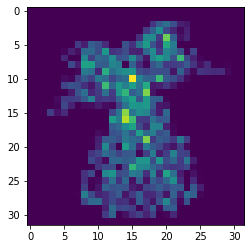

In [42]:
plt.imshow(images[9990].reshape(32, 32))

In [43]:
torch.save(images, "images/images_noiseless_1d_no_rot.pt")
torch.save(indices, "images/indices_noiseless_1d_no_rot.pt")

In [14]:
images = torch.load("images/images_noiseless_1d_no_rot.pt")
indices = torch.load("images/indices_noiseless_1d_no_rot.pt")

In [44]:
density_estimator_build_fun = posterior_nn(model='maf', hidden_features=200, num_transforms=8)

inference = SNPE(prior=prior_sbi, density_estimator=density_estimator_build_fun)


# Calculate and save posterior
posteriors = {}

# Train multiple posteriors for different noise levels
snr_training = [0.1]

for snr in snr_training:
    
    ##### Post processing images #####
    images_with_noise = add_noise_to_dataset(images, args_dict, snr) 
    images_with_noise = normalize_dataset(images_with_noise)
    ##### Post processing images #####
    
    inference = inference.append_simulations(indices, images_with_noise)

    density_estimator = inference.train()
    posterior_0_1d = inference.build_posterior(density_estimator)

#inference = inference.append_simulations(indices, images)

#density_estimator = inference.train()
#posterior_0_1d = inference.build_posterior(density_estimator)

/mnt/home/pcossio/virtual_envs/sbi_env/lib/python3.8/site-packages/sbi/neural_nets/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 22 epochs.

In [27]:
with open("posteriors/posterior_1d_no_rot_norm.pkl", "wb") as handle:
    pickle.dump(posterior_0_1d, handle)

In [20]:
with open("posteriors/posterior_1d_no_rot_norm.pkl", "rb") as handle:
    posterior_0_1d = pickle.load(handle)

In [28]:
true_index_1d = prior_sbi.sample((1,))

In [34]:
obs_img_1d = simulator_plain(true_index_1d)

print (true_index_1d)

obs_img_1d = torch.tensor(obs_img_1d.reshape(1, -1))


n_samples = 10000

samples_1d = posterior_0_1d.sample((n_samples,), x=obs_img_1d)

tensor([[2.0128]])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

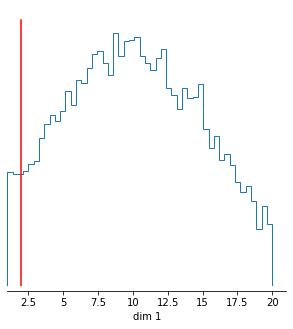

In [35]:
fig, axes = analysis.pairplot(samples_1d,
                           limits=[[1,21], [1,21]],
                           #ticks=[[2,10], [2,10]],
                           figsize=(5,5),
                           points=true_index_1d,
                           points_offdiag={'markersize': 6},
                           points_colors='r');